### Sampling from a GP

In [1]:
import numpy as np
from jax import grad, vmap, jit
import matplotlib.pyplot as plt
from kernels import *

In [2]:
xtrain = np.linspace(0,1,100)

In [3]:
def GPsampler(kernel, kparams, reg,  X, seed, nsamples):
  '''
  kernel: Covariance function.
  kparams: List of parameters of kernel.
  reg: Regularization for kernel matrix.
  X: Domain to get the sample.
  seed: Seed to reproduce the experiment.
  nsamples: Number of samples.
  '''
  N = len(X)
  kernel_matrix = K(kernel, X, X, kparams) + reg*np.eye(N)
  chol_factor = np.linalg.cholesky(kernel_matrix)
  np.random.seed(seed)
  normal_samples = np.random.normal(0, 1, (N,nsamples))
  get_sample = np.dot(chol_factor,normal_samples)
  return get_sample

In [4]:
gp = GPsampler(Gaussian, 0.3, 1e-6, xtrain, 2023, 5)

In [5]:
gp.shape

(100, 5)

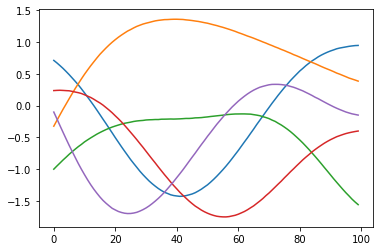

In [6]:
for i in range(5):
  plt.plot(gp[:,i])